In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import scipy as sc

In [2]:
img_size=(240, 320)
img_channels = 3
batch_size=32
epochs = 300

In [3]:
model_name = 'simple_covnet_model.tf'

In [4]:
train_size = 1000
validation_size = 500
test_size = 500

# Load the DataSet

Dataset citation:
- From Semi-Supervised to Transfer Counting of Crowds
C. C. Loy, S. Gong, and T. Xiang
in Proceedings of IEEE International Conference on Computer Vision, pp. 2256-2263, 2013 (ICCV)
- Cumulative Attribute Space for Age and Crowd Density Estimation
K. Chen, S. Gong, T. Xiang, and C. C. Loy
in Proceedings of IEEE Conference on Computer Vision and Pattern Recognition, pp. 2467-2474, 2013 (CVPR, Oral)
- Crowd Counting and Profiling: Methodology and Evaluation
C. C. Loy, K. Chen, S. Gong, T. Xiang
in S. Ali, K. Nishino, D. Manocha, and M. Shah (Eds.), Modeling, Simulation and Visual Analysis of Crowds, Springer, vol. 11, pp. 347-382, 2013
- Feature Mining for Localised Crowd Counting
K. Chen, C. C. Loy, S. Gong, and T. Xiang
British Machine Vision Conference, 2012 (BMVC)

In [5]:
dataset_path = '/Users/olove/Library/CloudStorage/OneDrive-Personal/AI datasets/CrowdCounter'

In [6]:
labels_df = pd.read_csv(dataset_path + '/labels.csv')
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
labels_df.drop("id", axis=1,inplace=True)
display(labels_df)

,count,image_name
0,35,seq_000001.jpg
1,41,seq_000002.jpg
2,41,seq_000003.jpg
3,44,seq_000004.jpg
4,41,seq_000005.jpg
...,...,...
1995,27,seq_001996.jpg
1996,27,seq_001997.jpg
1997,25,seq_001998.jpg
1998,26,seq_001999.jpg


In [7]:
labels_df = labels_df.sample(frac=1).reset_index(drop=True)
display(labels_df)

,count,image_name
0,26,seq_001989.jpg
1,41,seq_001020.jpg
2,25,seq_000620.jpg
3,20,seq_000584.jpg
4,42,seq_000993.jpg
...,...,...
1995,29,seq_001702.jpg
1996,33,seq_000701.jpg
1997,45,seq_001334.jpg
1998,33,seq_001162.jpg


In [8]:
if (train_size+validation_size+test_size) != len(labels_df):
    print('Dataset size is different from specified class sizes')
    exit(1)

training_df = labels_df[:train_size]
validation_df = labels_df[train_size:train_size+validation_size].reset_index(drop=True)
test_df = labels_df[train_size+validation_size:].reset_index(drop=True)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    
)

x_col_name = 'image_name'
y_col_name = 'count'

train_generator = datagen.flow_from_dataframe(
    training_df, 
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validation_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

Found 1000 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


# Define the model

In [10]:
inputs = keras.Input(shape= img_size + (img_channels,))

## Custom Simple Covnet

Downsizing using strides instead of MaxPolling in order to conserve location data

In [11]:
def basic_covnet_block(input):
    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
    return x

2023-12-10 12:22:34.345749: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-10 12:22:34.345774: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-10 12:22:34.345779: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-10 12:22:34.345809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 12:22:34.345821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Output Layer

In [12]:
def basic_dense_block(covnet, size):
    x = layers.Flatten()(covnet)
    outputs = layers.Dense(size, activation="relu")(x)
    outputs = layers.Dropout(0.5)(outputs)
    outputs = layers.Dense(1)(outputs)
    return outputs

In [13]:
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 119, 159, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 79, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 39, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 144768)            0         
                                                                 
 dense (Dense)               (None, 128)               18530432  
                                                                 
 dropout (Dropout)           (None, 128)               0     

# Train model

In [15]:
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
# TODO: Try mae vs accuracy. mae should be better since we are adjusting it to get closer to the actual value

In [16]:
callbacks_list = [
#    keras.callbacks.EarlyStopping(
#        monitor="val_loss", patience=4
#    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        monitor="val_loss",
        save_best_only=True
    ),
    keras.callbacks.TensorBoard()
]

In [17]:
Wsave = model.get_weights()

In [18]:
model.set_weights(Wsave)
history = model.fit(train_generator,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
)

Epoch 1/300


2023-12-10 12:22:34.898125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 110.4414 - mae: 7.9133INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 5s 153ms/step - loss: 110.4414 - mae: 7.9133 - val_loss: 65.6241 - val_mae: 6.5873
Epoch 2/300
32/32 [==============================] - ETA: 0s - loss: 64.8544 - mae: 6.3916INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 4s 140ms/step - loss: 64.8544 - mae: 6.3916 - val_loss: 53.9420 - val_mae: 5.7327
Epoch 3/300
32/32 [==============================] - ETA: 0s - loss: 45.8892 - mae: 5.4339INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 4s 136ms/step - loss: 45.8892 - mae: 5.4339 - val_loss: 28.4362 - val_mae: 4.0901
Epoch 4/300
32/32 [==============================] - 4s 113ms/step - loss: 22.8593 - mae: 3.8165 - val_loss: 43.6286 - val_mae: 5.5803
Epoch 5/300
32/32 [==============================] - ETA: 0s - loss: 17.6260 - mae: 3.3498INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 4s 138ms/step - loss: 17.6260 - mae: 3.3498 - val_loss: 19.3432 - val_mae: 3.6023
Epoch 6/300
32/32 [==============================] - 4s 114ms/step - loss: 11.3619 - mae: 2.6839 - val_loss: 22.4532 - val_mae: 3.8713
Epoch 7/300
32/32 [==============================] - 4s 114ms/step - loss: 10.1231 - mae: 2.4968 - val_loss: 22.7793 - val_mae: 3.8422
Epoch 8/300
31/32 [============================>.] - ETA: 0s - loss: 6.7161 - mae: 2.0505INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 4s 129ms/step - loss: 6.7426 - mae: 2.0516 - val_loss: 13.1568 - val_mae: 2.8648
Epoch 9/300
32/32 [==============================] - 4s 112ms/step - loss: 6.1682 - mae: 1.9521 - val_loss: 26.7913 - val_mae: 4.4916
Epoch 10/300
32/32 [==============================] - 4s 118ms/step - loss: 7.6218 - mae: 2.1839 - val_loss: 21.3962 - val_mae: 3.6826
Epoch 11/300
32/32 [==============================] - 4s 117ms/step - loss: 5.1643 - mae: 1.7894 - val_loss: 14.4394 - val_mae: 3.0224
Epoch 12/300
32/32 [==============================] - 4s 116ms/step - loss: 11.6619 - mae: 2.6473 - val_loss: 29.6188 - val_mae: 4.4435
Epoch 13/300
32/32 [==============================] - 4s 116ms/step - loss: 7.5940 - mae: 2.1634 - val_loss: 21.0889 - val_mae: 3.8959
Epoch 14/300
32/32 [==============================] - 4s 117ms/step - loss: 4.5959 - mae: 1.6718 - val_loss: 22.2861 - val_mae: 4.0203
Epoch 15/300
32/32 [==============================] - 4s 115ms/step 

INFO:tensorflow:Assets written to: simple_covnet_model.tf/assets


32/32 [==============================] - 5s 143ms/step - loss: 2.0925 - mae: 1.0334 - val_loss: 11.6925 - val_mae: 2.7266
Epoch 254/300
32/32 [==============================] - 4s 121ms/step - loss: 23.5771 - mae: 3.8180 - val_loss: 15.6358 - val_mae: 3.0699
Epoch 255/300
32/32 [==============================] - 4s 120ms/step - loss: 34.3880 - mae: 4.3307 - val_loss: 20.6167 - val_mae: 3.4888
Epoch 256/300
32/32 [==============================] - 4s 120ms/step - loss: 3.6828 - mae: 1.4944 - val_loss: 23.8625 - val_mae: 3.9155
Epoch 257/300
32/32 [==============================] - 4s 120ms/step - loss: 2.3019 - mae: 1.1835 - val_loss: 28.3231 - val_mae: 4.3740
Epoch 258/300
32/32 [==============================] - 4s 125ms/step - loss: 1.5993 - mae: 0.9904 - val_loss: 24.5952 - val_mae: 4.0309
Epoch 259/300
32/32 [==============================] - 4s 131ms/step - loss: 1.1080 - mae: 0.8069 - val_loss: 22.9785 - val_mae: 3.8718
Epoch 260/300
32/32 [==============================] - 4s 13

In [19]:
model.evaluate(validation_generator)

16/16 [==============================] - 1s 82ms/step - loss: 19.6147 - mae: 3.5230


[19.614715576171875, 3.522955894470215]

In [20]:
model.evaluate(test_generator)

16/16 [==============================] - 1s 91ms/step - loss: 19.4326 - mae: 3.4779


[19.432600021362305, 3.4778807163238525]

# Represent history

In [30]:
print(history.history.keys())
epochs = (0, 100)

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


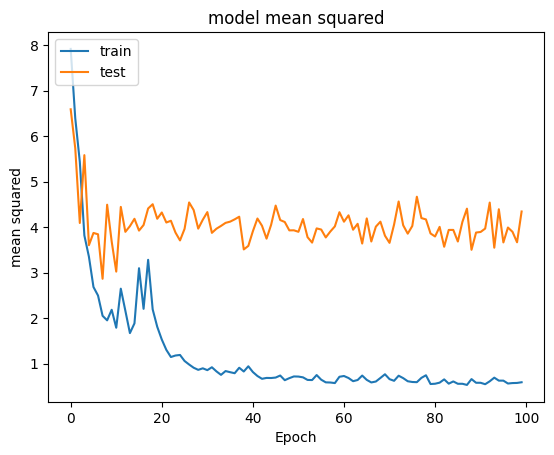

In [31]:
plt.plot(history.history['mae'][epochs[0]:epochs[1]])
plt.plot(history.history['val_mae'][epochs[0]:epochs[1]])
plt.title('model mean squared')
plt.ylabel('mean squared')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

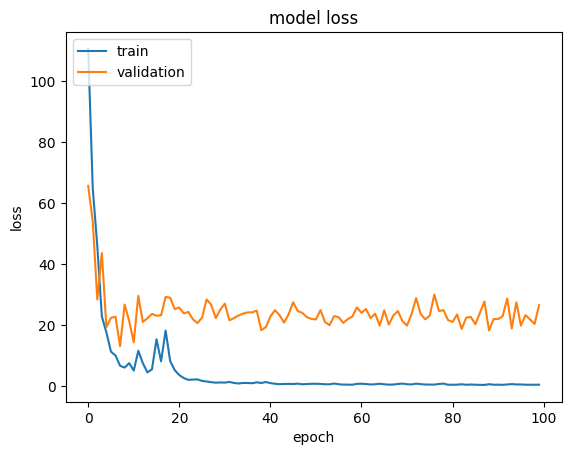

In [33]:
plt.plot(history.history['loss'][epochs[0]:epochs[1]])
plt.plot(history.history['val_loss'][epochs[0]:epochs[1]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()